<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/AUEM/Taller_20241217/ESE_preprocesamiento_zona_estudio_con_reduccion_nubes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo 2024.12.17
## Ensenada
### Visuzlización de zona de estudio en Colab - GEE
### Vesión con el proceso de generar mosaico para combinar imagenes de varias zonas y/o para eliminar nubes


In [43]:
## Definir variables

## Prefilo de zona
prefijo = "ESE"

## Ruta en Google Drive (se requiere crear una carpeta en raíz de Google Drive)
ruta = "Colab Data"

## Punto de centro de zona en coordenadas geográficas
punto_interes_text = [-116.6064, 31.8680]

## Proyeccion UTM aplicable
projection_text = "EPSG:32611"

## limites de rectangulo de zona de estudio en UTM
#limites_utm = [531951, 547066, 3513217, 3532728]    # versión agosto 2024
limites_utm = [523989, 547709, 3503560, 3532709]

## tamaño de pixel
pixel = 30

## número de pixeles máximo en segmento
max_tile = 50000

## fechas para imagenes de satelite
#inicio_2015 = "2015-02-01"
#final_2015 = "2015-06-30"

## datos para definición de rango de fechas imagenes de satelite
## rango de meses
m_inicio = 2
m_final = 6
## rango de años
y_inicio_2015 = 2015
y_final_2015 = 2015

## bandas de L8 utiles
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']

## bandas de capa de referencia
bands_B = ['settlement']
#bands_B = ['WSF']

#### Praparar el entorno

In [22]:
## cargar bibliotecas GEE y GEEmap
import ee
import geemap
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt


# Iniciar autentificacion
ee.Authenticate()

# Inicializar proyecto GEE
ee.Initialize(project='ee-vshalisko')

## Inicializar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Preparar datos para GEE

In [3]:
punto_interes = ee.Geometry.Point(punto_interes_text)

projection = ee.Projection(projection_text)

bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], projection, True, False)

#### Definir funciones auxiliares para control de nubes y calidad de pixeles

In [4]:
## funcion para eliminar nubes y sombras
def maskClouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 4)
    cloud_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(cloud_mask)

#### Seleccionar imagen Landsat 8 para el año 2015

In [5]:
## Ejemplo de coleccion con presencia de nubes
L8_collection_2015 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(m_inicio,m_final,"month"))
                      .filter(ee.Filter.calendarRange(y_inicio_2015, y_final_2015, "year"))
                      .filter(ee.Filter.lessThan("CLOUD_COVER", 4)))

print('Capas de datos filtrados 2015:', L8_collection_2015.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image_2015 = L8_collection_2015.first()
image_meta_2015 = L8_image_2015.getInfo()
imagename_2015 = image_meta_2015.get('properties',{}).get('LANDSAT_PRODUCT_ID')
print('Imagen 2015 elegido:', imagename_2015)

## obtener lista de nombres de bandas
bands_original_names = L8_image_2015.bandNames();

## Extraer datos de proyeccion de la imagen L8
projection = L8_image_2015.projection().getInfo();

## Consultar datos de la proyección
print(projection.get('crs'))
print(projection.get('transform'))

## generar el mosaico de 2015
L8_image_2015_mosaic = L8_collection_2015.map(maskClouds).reduce(ee.Reducer.mean())

## renombrar bandas al esquema original
L8_image_2015_mosaic = L8_image_2015_mosaic.rename(bands_original_names)

## asignar proyeccion al mosaico
L8_image_2015_re = L8_image_2015_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)

Capas de datos filtrados 2015: 2
Imagen 2015 elegido: LC08_L2SP_039038_20150606_20200909_02_T1
EPSG:32611
[30, 0, 479985, 0, -30, 3628215]


#### Cargar y preparar datos categoricos para 2015

In [49]:
# Cargar builtup 2015 (res 10 m) y reclasificar a 0 y 1
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')
built_2015_hr = built_2015_hr.where(built_2015_hr.eq(255), 1)

# Cargar cuerpor de agua (res 30)
elev_dataset = ee.ImageCollection('COPERNICUS/DEM/GLO30').filterBounds(L8_image_2015.geometry())
print('Segmentos WBM filtrados:', elev_dataset.size().getInfo())
MDE_Copernicus_proj = elev_dataset.first().projection()
water_mosaico = elev_dataset.select('WBM').mosaic()
water_mosaico = water_mosaico.setDefaultProjection(MDE_Copernicus_proj)
water_binary = water_mosaico.gt(0)

## Datos categoricas deben quedar en misma proyección de Landsat 8, con mismo tamaño y resolución
## Reproyectar layers
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
water_binary_reprojected = water_binary.reproject(projection.get('crs'), projection.get('transform'))

## Combinar capas de builtup y agua en una capa categorica de tres clases (0 - no-urbano, 1 - agua, 2 - urbano)
built_2015_agua_hr_reprojected = built_2015_hr_reprojected.unmask(0)
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(built_2015_agua_hr_reprojected.eq(1), 2))
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(water_binary_reprojected.eq(1), 1))

## renombrar capa resultante
built_2015_hr_reprojected = built_2015_hr_reprojected.rename(bands_B)

## renombrar capa resultante
built_2015_agua_hr_reprojected = built_2015_agua_hr_reprojected.rename(bands_B)
print(built_2015_agua_hr_reprojected.getInfo())

Segmentos WBM filtrados: 8
{'type': 'Image', 'bands': [{'id': 'settlement', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:32611', 'crs_transform': [30, 0, 479985, 0, -30, 3628215]}], 'version': 1728918335381151, 'id': 'DLR/WSF/WSF2015/v1', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 6718369799}}


#### Visualizar datos en GEE

In [45]:
## Parametros de visualizacion del poligono
visPol = {
  'color': '0000FF',
  'width': 2,
  'opacity': 0.25
};

## Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
}

## Parametros de visualizacion para capa categorica
vizBuiltupAgua = {
   'min': 0,
   'max': 2,
  'palette': ['beige', 'blue', 'black']
}

## definir ventana de mapa
map = geemap.Map()

## Centrar
map.centerObject(punto_interes, 10)


## Agregar capas de datos al mapa
map.addLayer(L8_image_2015, vizParams_L8, "2015 solo Composición de falso color", False, 0.5)
map.addLayer(L8_image_2015_re, vizParams_L8, '2015 mosaic Composición de falso color', True, 0.5)
map.addLayer(built_2015_agua_hr_reprojected, vizBuiltupAgua, 'referencia categorica', True, 0.5)
map.addLayer(bbox, visPol, "Area de estudio", True, 1)
map.addLayer(punto_interes, {}, "Punto de centro", True, 1)


## Presentar el mapa
map

Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Definición de los segmentos para descarga y conversión de datos desde GEE a numpy

In [16]:
def segmentation(limits, pixel_size, max_tile_size, proj):
  alto = math.ceil((limits[3] - limits[2]) / pixel_size)
  print('Alto del segmento (pixeles)', alto)
  ancho = math.ceil(max_tile_size / alto)
  print('Ancho del segmento (pixeles)', ancho)
  incremento = ancho * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  seq = list(np.arange(limits[0], limits[1], incremento))
  print('Secuencia de marcas de longitud para los segmentos')
  print(seq)

  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)

  return segments

segment_list = segmentation(limites_utm, pixel, max_tile, projection_text)

## Agregar capas de datos al mapa 1
map1 = geemap.Map()
map1.centerObject(punto_interes, 10)
map1.addLayer(bbox, {}, 'Area de estudio', False, 0.5)

for i in range(len(segment_list)):
  segment_name = "segment " + str(i)
  map1.addLayer(segment_list[i], {}, segment_name, True, 0.3)

## Presentar el mapa
map1

Alto del segmento (pixeles) 972
Ancho del segmento (pixeles) 52
Ancho del segmento (unidades de proyeccion) 1560
Secuencia de marcas de longitud para los segmentos
[523989, 525549, 527109, 528669, 530229, 531789, 533349, 534909, 536469, 538029, 539589, 541149, 542709, 544269, 545829, 547389]


Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Funciones para descarga y conversión de datos GEE

In [18]:
def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np

def merge_feature_array(image, segments, bands):
  ## combinaccion de segmentos
  array_feature = tile_to_numpy(image, segments[0], bands)
  print("New feature array", array_feature.shape)
  for segment in segments[1:]:
    feature_segment = tile_to_numpy(image, segment, bands)
    print("Feature segment", feature_segment.shape)
    array_feature = np.concatenate((array_feature, feature_segment), 1)
  print("Full new feature array", array_feature.shape)
  return array_feature

#### Descarga Landsat 8 para 2015

New feature array (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Feature segment (973, 53, 6)
Full new feature array (973, 795, 6)


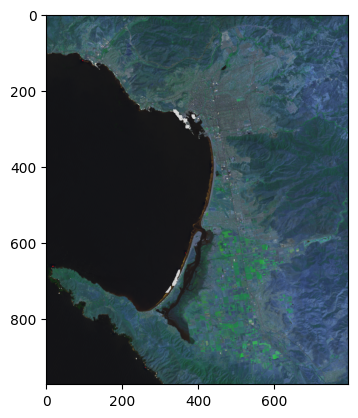

In [38]:
array_feature_2015 = merge_feature_array(L8_image_2015_re, segment_list, bands_L8)

# Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (255*((array_feature_2015 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Descarga datos categoricos 2015

New feature array (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Full new feature array (973, 795, 1)


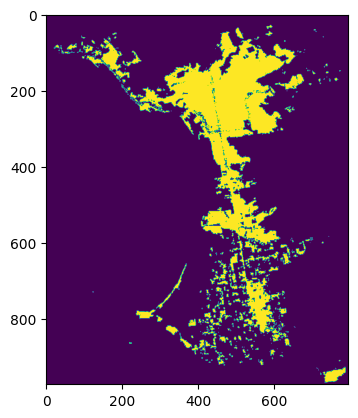

Valores únicos de clases [0 1]
Conteo de pixeles de valores únicos [670802 102733]
New feature array (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Feature segment (973, 53, 1)
Full new feature array (973, 795, 1)


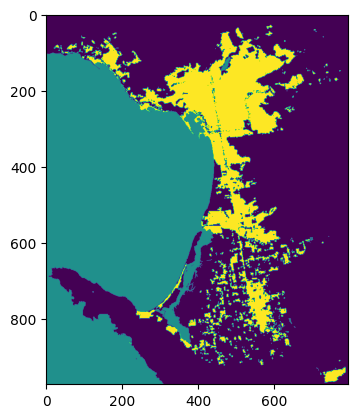

Valores únicos de clases [0 1 2]
Conteo de pixeles de valores únicos [396596 275135 101804]


In [50]:
## Variante de capa binaria
array_target_binary_2015 = merge_feature_array(built_2015_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_binary_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values_bin, occurrence_count_bin = np.unique(array_target_binary_2015, return_counts=True)
print('Valores únicos de clases', unique_values_bin)
print('Conteo de pixeles de valores únicos', occurrence_count_bin)

## Variante de capa de tres clases
array_target_2015 = merge_feature_array(built_2015_agua_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values, occurrence_count = np.unique(array_target_2015, return_counts=True)
print('Valores únicos de clases', unique_values)
print('Conteo de pixeles de valores únicos', occurrence_count)

#### Guardar datos en numpy arrays en Google Drive

In [52]:
ruta_L8_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.npy"
print(ruta_L8_2015)

ruta_target_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.npy"
print(ruta_target_2015)

ruta_target_binary_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.npy"
print(ruta_target_binary_2015)

np.save(ruta_L8_2015, array_feature_2015)
np.save(ruta_target_2015, array_target_2015)
np.save(ruta_target_binary_2015, array_target_binary_2015)

/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.npy
